In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask
import dask.dataframe as ddf
import numpy as np
from tqdm import tqdm
import pickle
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
hgg = pd.read_parquet('/scratch365/cmoore24/training/data/no_subcut/hgg.parquet')
hbb = pd.read_parquet('/scratch365/cmoore24/training/data/no_subcut/hbb.parquet')

In [4]:
pick = hgg
title = 'hgg'
# pick = hbb
# title = 'hbb'
print(len(pick))

142783


In [5]:
pick = pick[pick['FatJets.msoftdrop'] < 140]
pick = pick[pick['FatJets.msoftdrop'] > 90]
pick = pick[pick['FatJets.pt'] < 600]
pick = pick[pick['FatJets.pt'] > 450]
print(len(pick))

45640


In [6]:
pick['FatJets.mratio'] = pick['FatJets.mass'].values/pick['FatJets.msoftdrop'].values

In [7]:
background = pd.read_parquet('/scratch365/cmoore24/training/data/no_subcut/qcd.parquet')
background['FatJets.mratio'] = background['FatJets.mass']/background['FatJets.msoftdrop']

In [8]:
background = background[background['FatJets.msoftdrop'] < 140]
background = background[background['FatJets.msoftdrop'] > 90]
background = background[background['FatJets.pt'] < 600]
background = background[background['FatJets.pt'] > 450]

In [9]:
var_keys = list(pick.keys())

In [10]:
items = [#'FatJets.area',
  #'FatJets.eta',
  #'FatJets.mass',
  #'FatJets.msoftdrop',
  'FatJets.n2b1',
  'FatJets.n3b1',
  #'FatJets.phi',
  #'FatJets.pt',
  'FatJets.nConstituents',
  'FatJets.color_ring',
  'FatJets.d2b1',
  'FatJets.u1',
  'FatJets.u2',
  'FatJets.u3',
  'FatJets.d3',
  'FatJets.m2',
  'FatJets.m3',
  'FatJets.n4',
  #'FatJets.mratio',
 'isSignal',
]

In [11]:
pick['isSignal'] = np.ones_like(pick[items[0]])

In [12]:
background['isSignal'] = np.zeros_like(background[items[0]])

In [13]:
# sizes = []
# for i in background:
#     sizes.append(len(background[i]))

# losses = [(x - min(sizes)) for x in sizes]
# for i in background:
#     background[i] = background[i][:min(sizes)]

In [14]:
small_sig = pick[items]
small_bkg = background[items]
#del(background)
#gc.collect()

In [15]:
# a = small_sig.keys()[0]

In [16]:
# x_range = (0.5,5)
# bins=40

In [17]:
# fig, ax = plt.subplots()
# plt.hist(small_bkg[a].values, range=x_range, bins=bins, density=True, histtype='step', label='QCD')
# plt.hist(small_sig[a].values, range=x_range, bins=bins, density=True, histtype='step', label='Hgg')
# plt.hist(small_sig2[a].values, range=x_range, bins=bins, density=True, histtype='step', label='Hgg')
# plt.legend()
# plt.title(f'Distribution for {a}')
# plt.show()

In [18]:
NDIM = len(items) - 1
df_all = pd.concat([small_sig, small_bkg])
dataset = df_all.values
X = dataset[:, 0:NDIM]
y = dataset[:, NDIM]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
with open(f'outputs/{title}_nosubcut_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# split_bkg = X_train[y_train == 0]
# split_sig  = X_train[y_train == 1]

In [23]:
# fig, ax = plt.subplots()
# plt.hist(split_bkg, range=x_range, bins=bins, density=True, histtype='step', label='QCD')
# plt.hist(split_sig, range=x_range, bins=bins, density=True, histtype='step', label='Hgg')
# plt.legend()
# plt.title(f'Distribution for {a}')
# plt.show()

In [24]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [40]:
# Build our model.
# gc.collect()
# torch.cuda.empty_cache()

class NeuralNetwork(nn.Module):
    def __init__(self, width=64):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(items)-1, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
#             nn.Linear(width, width2),
#             nn.ReLU(),
#             nn.Linear(width2, width2),
#             nn.ReLU(),
#             nn.Linear(width2, width),
#             nn.ReLU(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

model= nn.DataParallel(model,device_ids = [0, 
                                           #1, 
                                           #2, 
                                           #3
                                          ])
model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
len(X_train)

429421

In [42]:
portion = 2**12
if portion > (len(X_train)*0.5):
    raise Exception('Batch size too big')
print(portion)

4096


In [43]:
losses, test_losses = [], []
min_loss, stale_epochs = 100.0, 0
stale_list = ['N/A']

batch_size = portion
for t in tqdm(range(100)):
    batch_loss, batch_test_loss = [], []
    
    for b in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[b : b + batch_size]
        y_batch = y_train[b : b + batch_size]
        model.train()
        y_pred = model(X_batch)
        #print(f"pred: {y_pred}")
        y_b = y_batch.view(-1,1)
        #print(f"y_b: {y_b}")

        # Compute and print loss.
        loss = loss_fn(y_pred, y_b)
        #print(f"loss: {loss.item()}")
        batch_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.inference_mode():

            model.eval()
            test_pred = model(X_test)

            test_label = y_test.view_as(test_pred)
            test_loss = loss_fn(test_pred, test_label)
            batch_test_loss.append(test_loss.item())

             
            # Monitor the loss function to prevent overtraining.
#             if stale_epochs > 20:
#                 stale_list.append(t)
#                 break

#             if test_loss.item() - min_loss < 0:
#                 min_loss = test_loss.item()
#                 stale_epochs = 0

#             else:
#                 stale_epochs += 1
#                 if stale_epochs % 5 == 0:
#                     print(stale_epochs)
    
    losses.append(np.mean(batch_loss))
    test_losses.append(np.mean(batch_test_loss))
#print(f'Stale at epoch {stale_list[1]}')
#torch.save(model.state_dict(), "pytorch_hgg_model.pth")

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


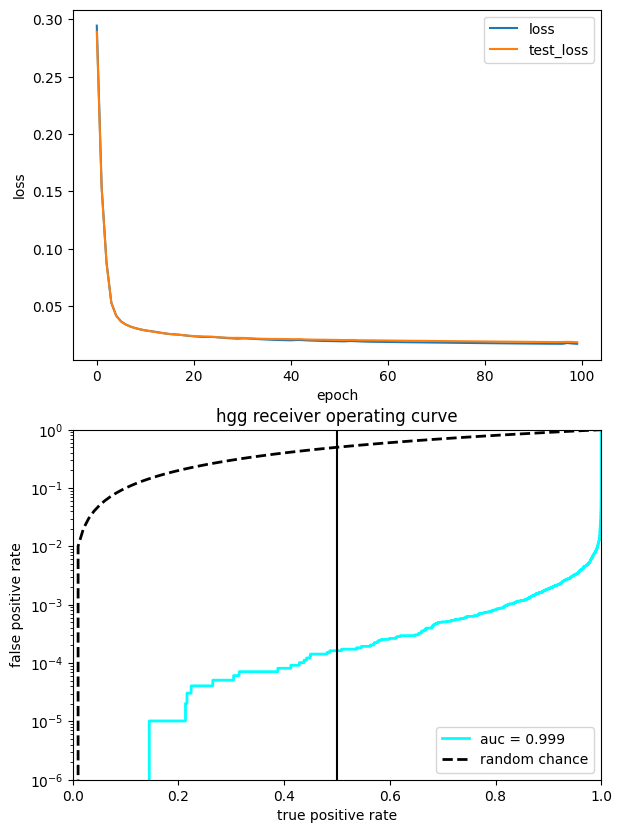

In [44]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses[:], label="loss")
    ax.plot(test_losses[:], label="test_loss")
    ax.legend(loc="upper right")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    #ax.set_ylim(0.03, 0.06)

    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.set_yscale("log")
    ax.plot(tpr, fpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([1e-6, 1.0])
    ax.set_xlabel("true positive rate")
    ax.set_ylabel("false positive rate")
    ax.set_title(f"{title} receiver operating curve")
    ax.legend(loc="lower right")
    ax.axvline(x=0.5, color='black')
    plt.show()

In [30]:
items2 = items[:-1]

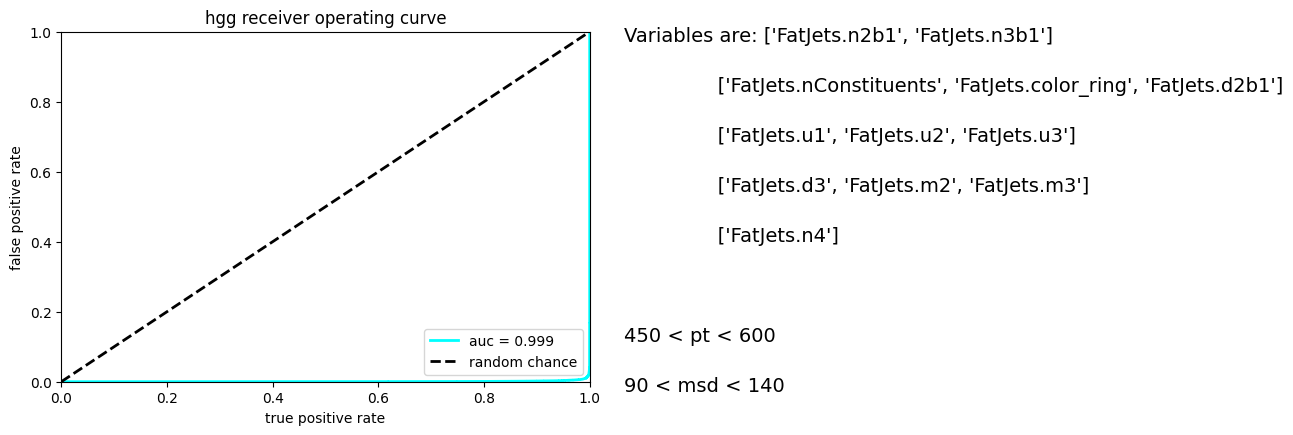

In [31]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
#     ax = plt.subplot(2, 2, 1)
#     ax.plot(losses, label="loss")
#     ax.plot(test_losses, label="test_loss")
#     ax.legend(loc="upper right")
#     ax.set_xlabel("epoch")
#     ax.set_ylabel("loss")

    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(tpr, fpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("true positive rate")
    ax.set_ylabel("false positive rate")
    ax.set_title(f"{title} receiver operating curve")
    ax.legend(loc="lower right")
    textstr1 = (f'Variables are: {str(items2[:len(items2)//6])}')
    textstr2 = (f'               {str(items2[len(items2)//6:len(items2)//6 + 3])}')
    textstr3 = (f'               {str(items2[len(items2)//6 + 3:len(items2)//6 + 6])}')
    textstr4 = (f'               {str(items2[len(items2)//6 + 6:len(items2)//6 + 9])}')
    textstr5 = (f'               {str(items2[len(items2)//6 + 9:len(items2)//6 + 13])}')
#     textstr6 = (f'               {str(items2[len(items2)//6 + 12:len(items2)//6 + 15])}')
    plt.gcf().text(0.5, 0.45, textstr1, fontsize=14)
    plt.gcf().text(0.5, 0.4, textstr2, fontsize=14)
    plt.gcf().text(0.5, 0.35, textstr3, fontsize=14)
    plt.gcf().text(0.5, 0.3, textstr4, fontsize=14)
    plt.gcf().text(0.5, 0.25, textstr5, fontsize=14)
#     plt.gcf().text(0.5, 0.2, textstr6, fontsize=14)
    plt.gcf().text(0.5, 0.15, '450 < pt < 600', fontsize=14)
    plt.gcf().text(0.5, 0.1, '90 < msd < 140', fontsize=14)
    plt.show()

In [32]:
bkg_out = Y_predict[y_test == 0].cpu()
bkg_out = bkg_out.numpy()

In [33]:
sig_out = Y_predict[y_test == 1].cpu()
sig_out = sig_out.numpy()

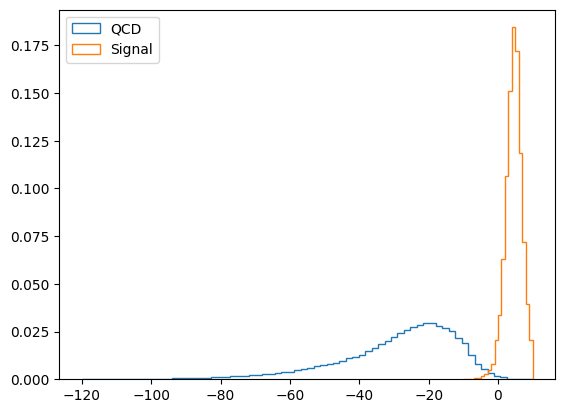

In [34]:
fig, ax = plt.subplots()
plt.hist(bkg_out, range=(-120,10), bins=70, density=True, histtype='step', label='QCD')
plt.hist(sig_out, range=(-10,10), bins=20, density=True, histtype='step', label='Signal')
plt.legend()
plt.show()

In [36]:
model = model.eval()
traced = torch.jit.trace(model.module.cpu(), X_test[0].cpu())

In [37]:
traced.save('outputs/hgg_nosubcut_traced_model.pt')

In [38]:
#torch.save(model, 'outputs/hgg_subcut_model.pt')

In [38]:
# hbb['FatJets.isSignal'] = np.ones_like(hbb['FatJets.particleNetMD_QCD'])
# background['FatJets.isSignal'] = np.zeros_like(background['FatJets.particleNetMD_QCD'])

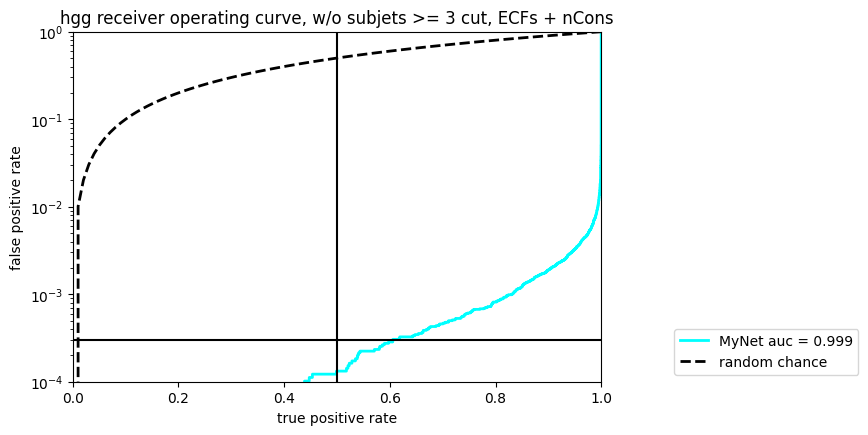

In [33]:
with torch.inference_mode(): 
    plt.figure(figsize=(15, 10))
    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    
#     arg1 = pd.concat([hbb['FatJets.isSignal'], background['FatJets.isSignal']])
#     arg2 = pd.concat([hbb['FatJets.particleNetMD_QCD'], background['FatJets.particleNetMD_QCD']])
    
#     arg3 = pd.concat([hbb['FatJets.particleNet_HbbvsQCD'], background['FatJets.particleNet_HbbvsQCD']])

#     fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
#     fpr2, tpr2, thresholds2 = roc_curve(arg1.values, arg2.values)
#     fpr3, tpr3, thresholds3 = roc_curve(arg1.values, arg3.values)
    roc_auc = auc(fpr, tpr)
#     roc_auc2 = auc(tpr2, fpr2)
#     roc_auc3 = auc(fpr3, tpr3)
    ax = plt.subplot(2, 2, 3)
    ax.set_yscale("log")
    ax.plot(tpr, fpr, lw=2, color="cyan", label="MyNet auc = %.3f" % (roc_auc))
#     ax.plot(fpr2, tpr2, lw=2, color="red", label="PN_MD auc = %.3f" % (roc_auc2))
#     ax.plot(tpr3, fpr3, lw=2, color="orange", label="PN_HbbvQCD auc = %.3f" % (roc_auc3))
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([1e-4, 1.0])
    ax.set_xlabel("true positive rate")
    ax.set_ylabel("false positive rate")
    ax.set_title(f"{title} receiver operating curve, w/o subjets >= 3 cut, ECFs + nCons")
    ax.legend(loc="lower right", bbox_to_anchor=(1.5, 0))
    plt.axvline(x=0.5, color='black')
    plt.axhline(y=3e-4, color='black')
#     plt.axhline(y=7.5e-4, color='black')
#     plt.axhline(y=6.5e-3, color='black')
    plt.show()